# Comparison of parameters for jet tagging in fast sim and full sim

Notes: 

- `jet_npfcand` and `jet_nconst` is the same / filled with the same value in full sim


In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_fullsim = "/home/saaumill/FullSimTagger/src/fullsim_tree.root"
path_fastsim = "/eos/experiment/fcc/ee/jet_flavour_tagging/winter2023/samples_v2/stage2_Hbb.root"

file_fu = uproot.open(path_fullsim)
tree_fu = file_fu["tree;1"]

file_fa = uproot.open(path_fastsim)
tree_fa = file_fa["tree;1"]

In [3]:
df_fa = tree_fa.arrays(entry_start=0, entry_stop=200, library="np")
df_fu = tree_fu.arrays(entry_start=0, entry_stop=200, library="np")

Check if trees have the same key. Apart from `['event_number','n_hit','n_part']` @Dolores why do we need them when initializing?

In [4]:
list_fu = [item for item in tree_fu.keys() if item not in ['event_number','n_hit','n_part']]

set_fa = set(tree_fa.keys())
set_fu = set(list_fu)

print(set_fa == set_fu)

True


Now let's check if the distributions look the same!

### recojet_isX

In [5]:
len(df_fu['recojet_isB'])

200

In [6]:
def histograms(keys, n, k, figsize=(13, 2), bins=50, conc=False):
    fig, axs = plt.subplots(n, k, figsize=figsize)
    
    for i, ax in enumerate(axs.flat):
        ax.set_title(keys[i])
        # set same range if not specified
        try:
            fa = df_fa[keys[i]]
            fu = df_fu[keys[i]]
            combined_min = min(fa.min(), fu.min())
            combined_max = max(fa.max(), fu.max())
            combined_range = (combined_min, combined_max)
        except ValueError:
            fa = np.concatenate(df_fa[keys[i]])
            fu = np.concatenate(df_fu[keys[i]])
            combined_min = min(fa.min(), fu.min())
            combined_max = max(fa.max(), fu.max())
            combined_range = (combined_min, combined_max)
        # plot
        if conc==False:
            ax.hist(df_fa[keys[i]], bins=bins, range=combined_range, alpha=0.55, label='FastSim') # set density=True to normalize
            ax.hist(df_fu[keys[i]], bins=bins, range=combined_range, alpha=0.55, label='FullSim')
        else: 
            ax.hist(np.concatenate(df_fa[keys[i]]), bins=bins, range=combined_range, alpha=0.55, label='FastSim') # set density=True to normalize
            ax.hist(np.concatenate(df_fu[keys[i]]), bins=bins, range=combined_range, alpha=0.55, label='FullSim')
    
    plt.legend()
    plt.tight_layout()

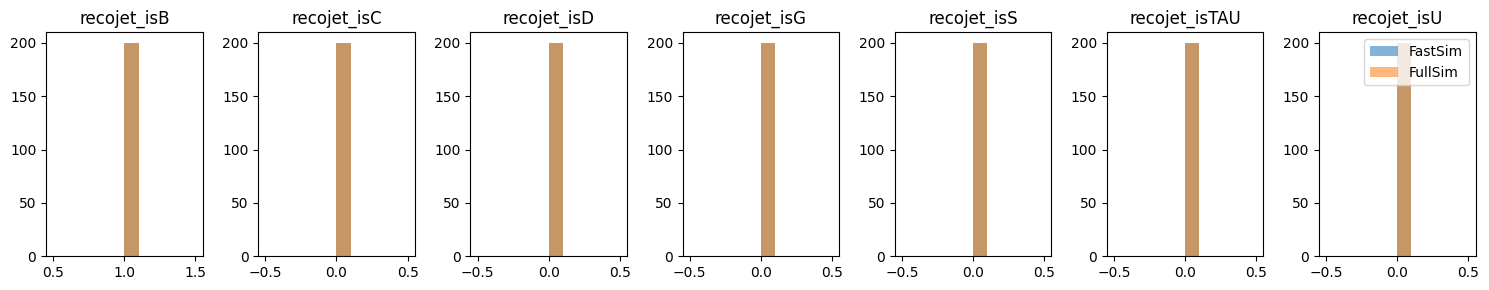

In [7]:
keys = ['recojet_isB',
 'recojet_isC',
 'recojet_isD',
 'recojet_isG',
 'recojet_isS',
 'recojet_isTAU',
 'recojet_isU']

histograms(keys, 1, 7, figsize=(15, 3), bins=10)

**Conclusion**: we see that in the full sim the reco PID of the quark is wrong! Although we have only b jets it classifies very jet as c ...

Well... not sure that goes wrong here. I definitely use b quarks for fullsim, why is it marked as c? I double checked the PDG IDs.

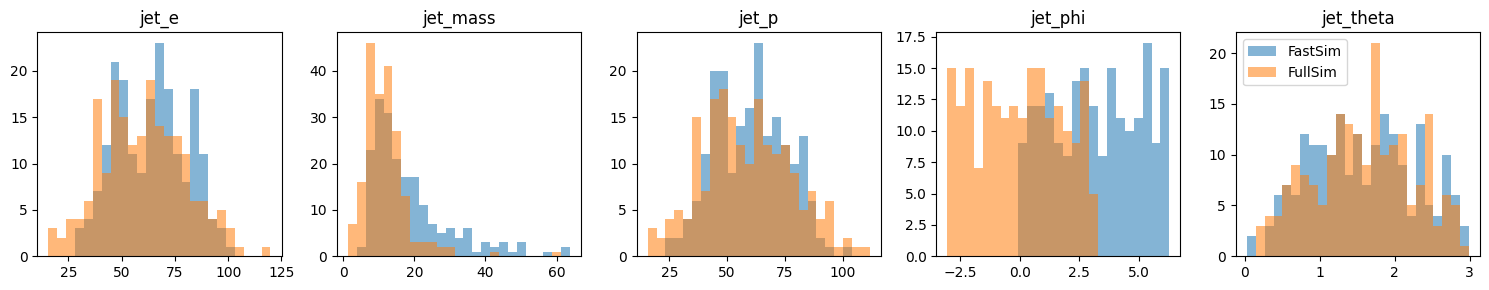

In [8]:
keys = ['jet_e',
 'jet_mass',
 'jet_p',
 'jet_phi',
 'jet_theta']


histograms(keys, 1, 5, figsize=(15, 3), bins=25)

- `jet_e` seems fine
- `jet_mass` seems fine
- `jet_p` seems fine
- `jet_phi` seems fine -> only other range! $\phi_{\mathrm{FullSim}} \in [-\pi, \pi]$ but $\phi_{\mathrm{FastSim}} \in [0, 2\pi]$
- `jet_theta` seems fine


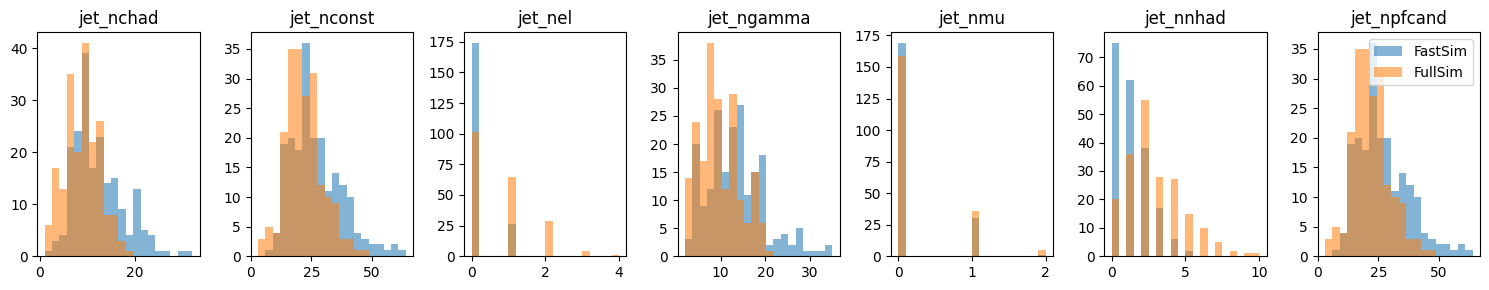

In [9]:
keys = ['jet_nchad',
 'jet_nconst',
 'jet_nel',
 'jet_ngamma',
 'jet_nmu',
 'jet_nnhad',
 'jet_npfcand']

histograms(keys, 1, 7, figsize=(15, 3), bins=20)

Reasonable enough?
-> more neutral hadrons than with fast sim... this should be fine as full sim just includes more "trash"

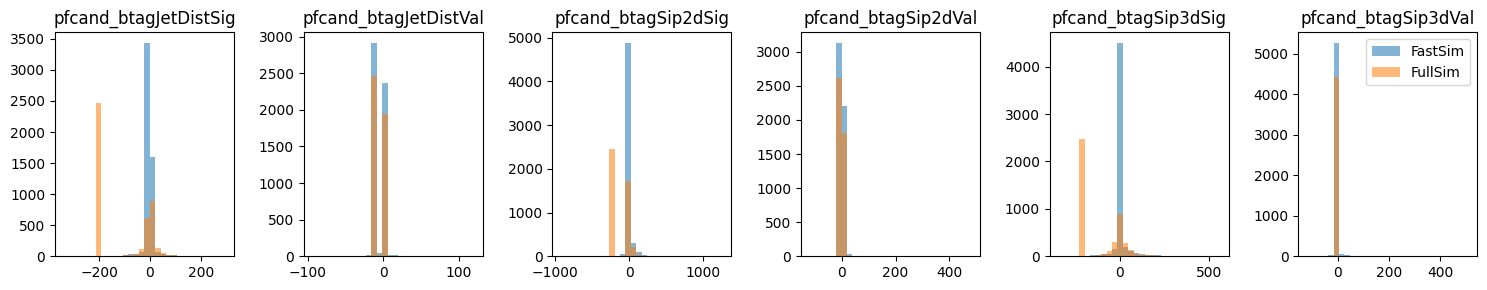

In [10]:
keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

histograms(keys, 1, 6, figsize=(15, 3), bins=30, conc=True)

Okay, Michele said that I should always compare the particles in a jet with the highest amount of energy and not the whole distribution because it might differ in the tails. So let's do that instead:

In [11]:
def get_index_highest_energy_particle(df, k=3, type=211):
    if df == 'fa':
        particles_e = df_fa['pfcand_e']
    elif df == 'fu':
        particles_e = df_fu['pfcand_e']
    index = np.zeros((particles_e.shape[0], k), dtype=int)
    for i  in range(particles_e.shape[0]):
        part_e = particles_e[i]
        ind = np.argpartition(part_e, -k)[-k:]
        ind = ind[np.argsort(part_e[ind])[::-1]]
        index[i] = ind
    return index

In [16]:
index_fa = get_index_highest_energy_particle("fa")
index_fu = get_index_highest_energy_particle("fu")

In [17]:
# Access the desired elements
def get_elements(df_value, index):
    return np.array([df_value[i][index[i]] for i in range(len(df_value))])


In [20]:
def plot_key_highest_e_part(key, k=3, range=None, bins=20, log=False):
    fig, axs = plt.subplots(1, k, figsize=(10,3))
    for i, ax in enumerate(axs.flat):
        a = get_elements(df_fa[key], index_fa)[:, i]
        b = get_elements(df_fu[key], index_fu)[:, i]

        if range == None:
            combined_min = min(a.min(), b.min())
            combined_max = max(a.max(), b.max())
            combined_range = (combined_min, combined_max)
        else:
            combined_range = range
        
        ax.set_title(key)
        ax.hist(a, bins=bins, alpha=0.55, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$')
        ax.hist(b, bins=bins, alpha=0.55, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$')
        if log:
            ax.set_yscale('log')
        ax.legend()
        
    plt.show()

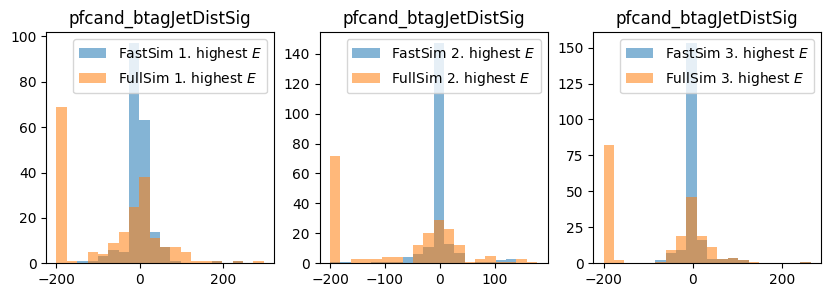

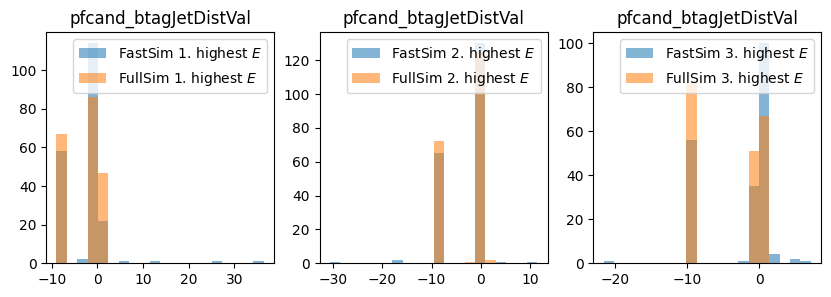

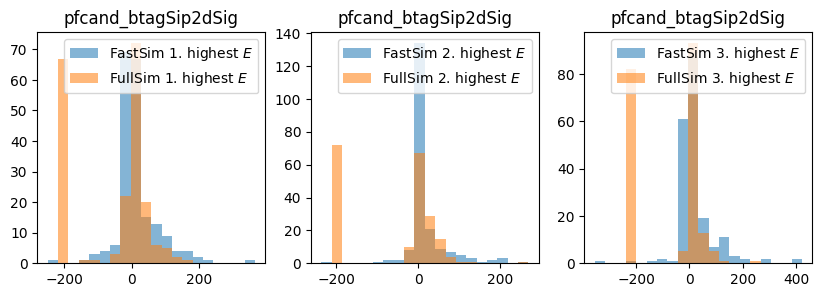

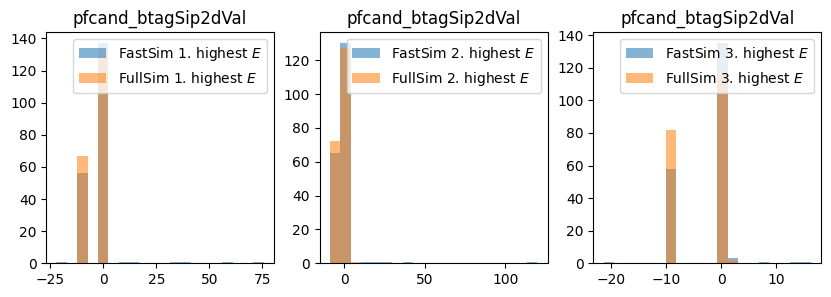

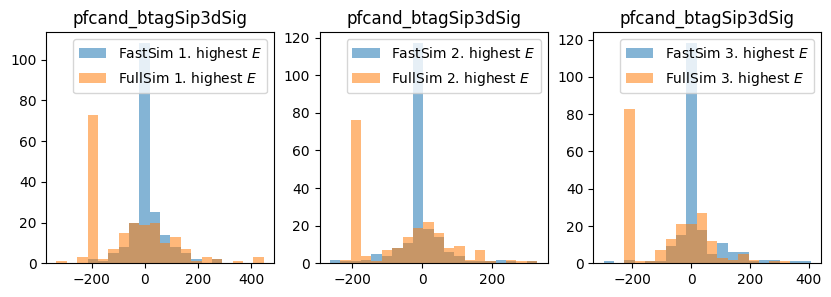

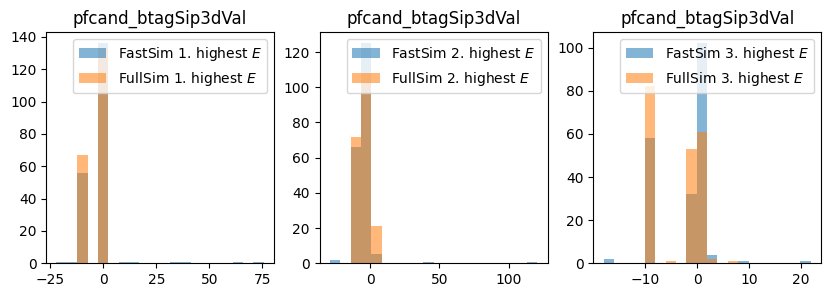

In [21]:
keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

for key in keys:
    plot_key_highest_e_part(key)

You see the difference of setting `Sig` to -200 instead of -9. 

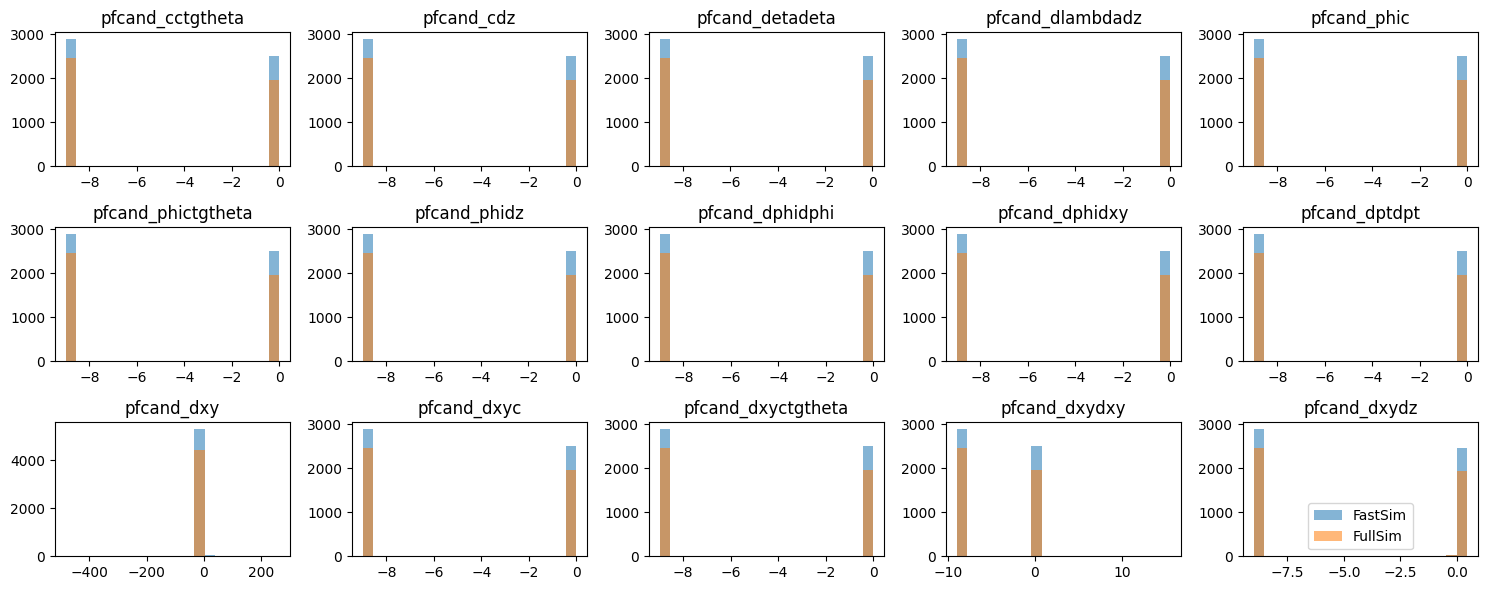

In [23]:
keys = ['pfcand_cctgtheta',
 'pfcand_cdz',
 'pfcand_detadeta',
 'pfcand_dlambdadz',
 'pfcand_phic',
 'pfcand_phictgtheta',
 'pfcand_phidz',
 'pfcand_dphidphi',
 'pfcand_dphidxy',
 'pfcand_dptdpt',
 'pfcand_dxy',
 'pfcand_dxyc',
 'pfcand_dxyctgtheta',
 'pfcand_dxydxy',
 'pfcand_dxydz',
 'pfcand_dz',
 'pfcand_dzdz']

histograms(keys, 3, 5, figsize=(15, 6), bins=20, conc=True)

Well, we see that at least the -9 makes sense. But let's check for the distributions for the highest energy particles. And cut the region where the -9 is to get a better understanding of the distributions

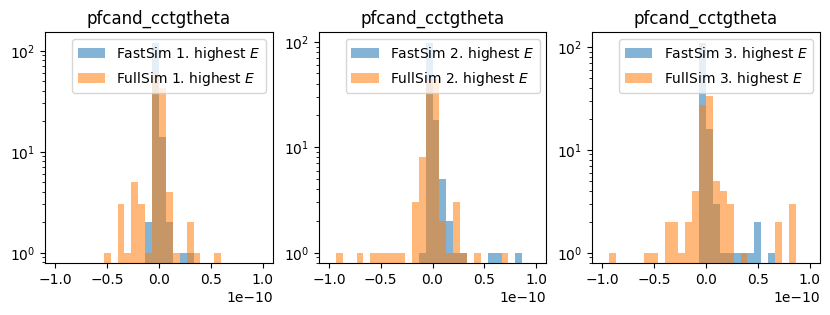

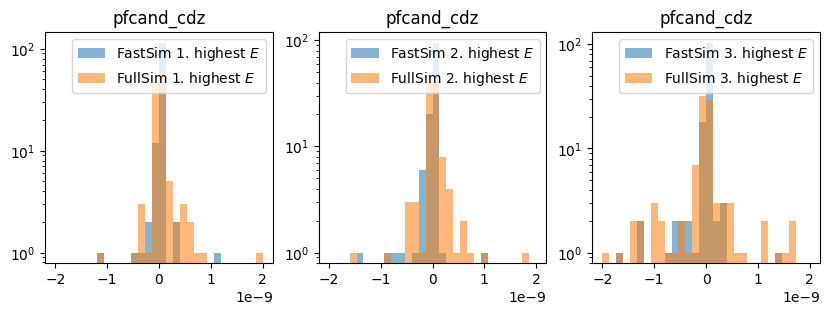

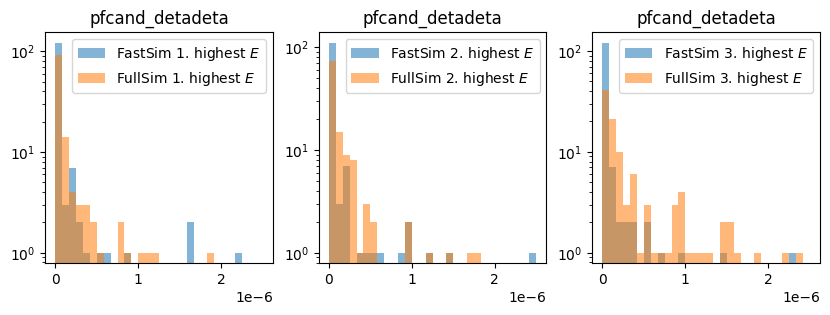

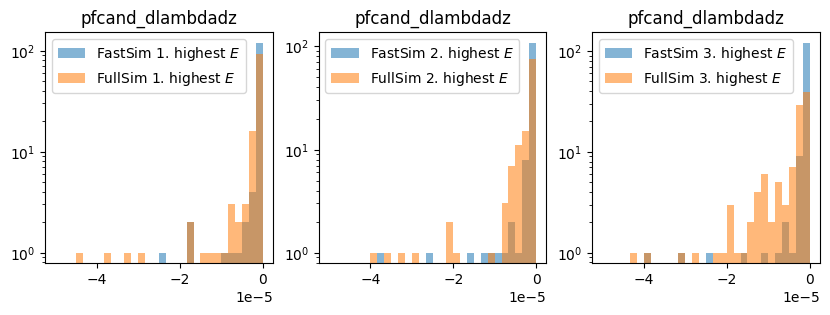

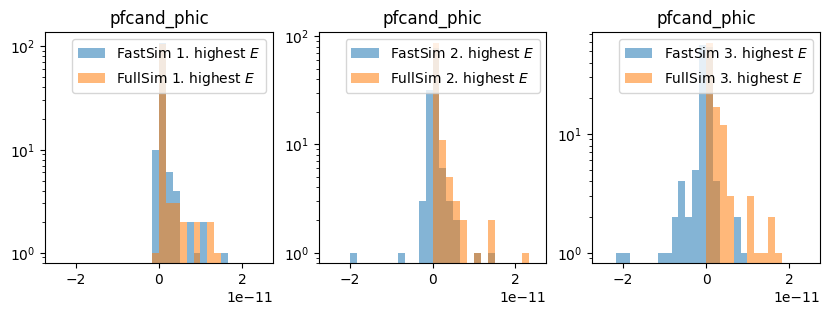

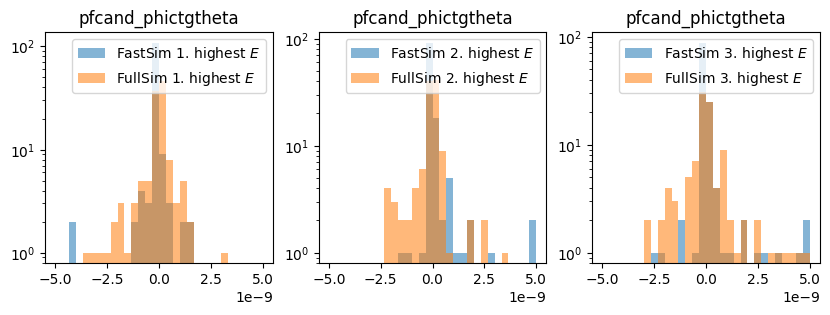

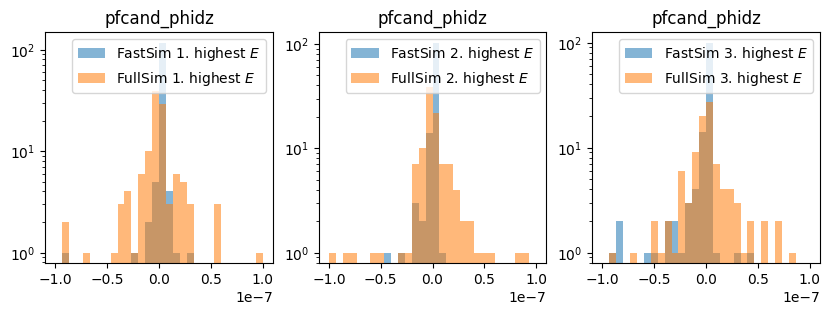

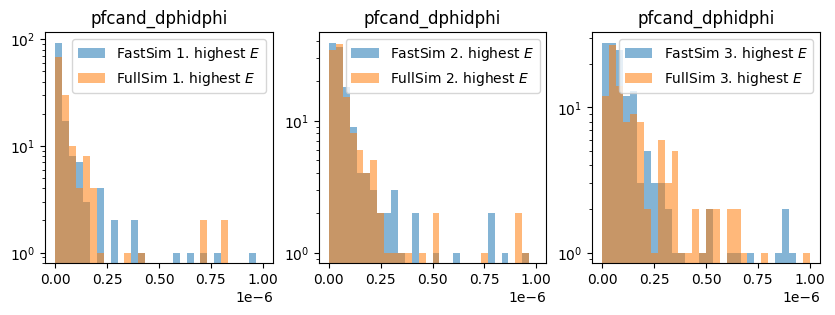

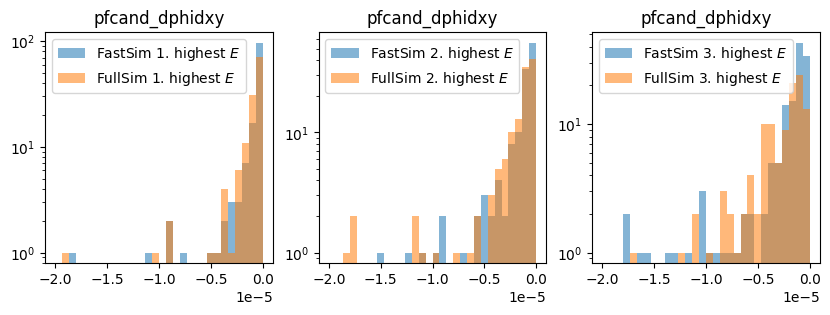

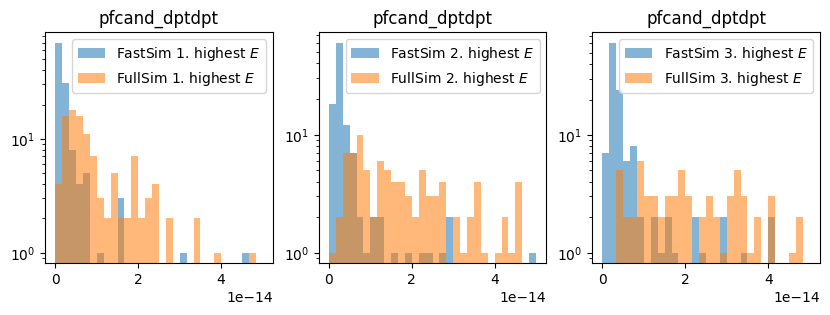

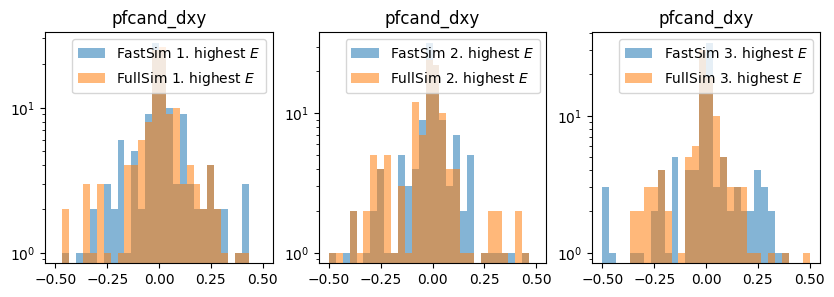

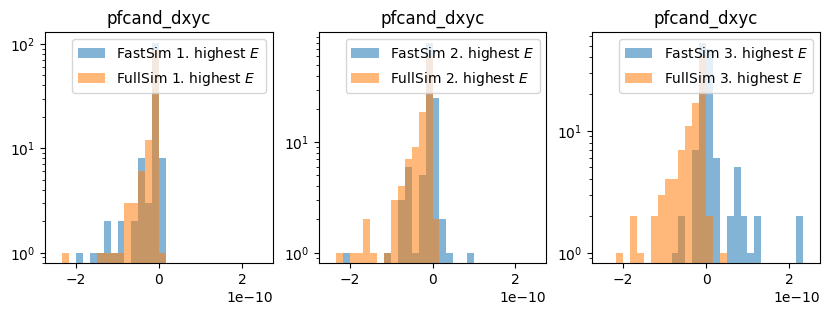

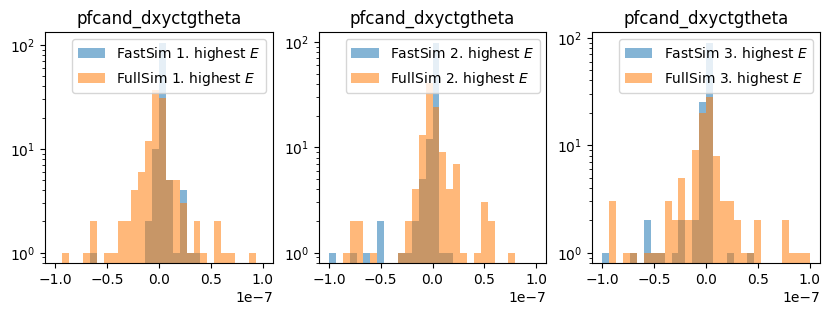

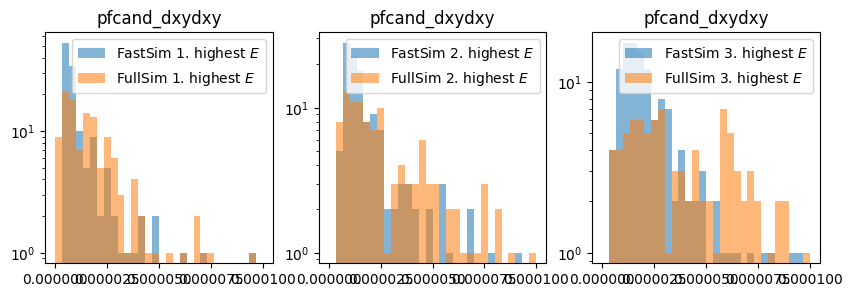

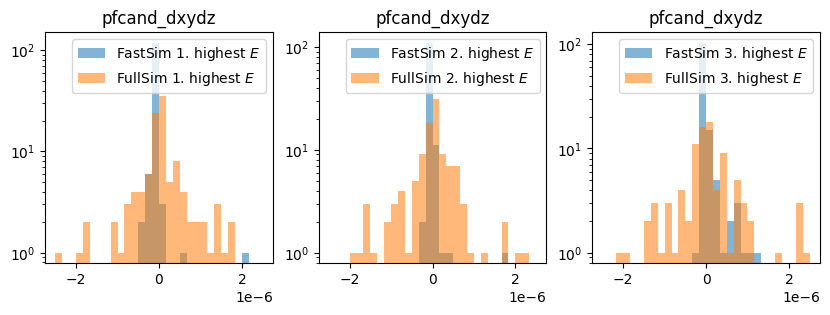

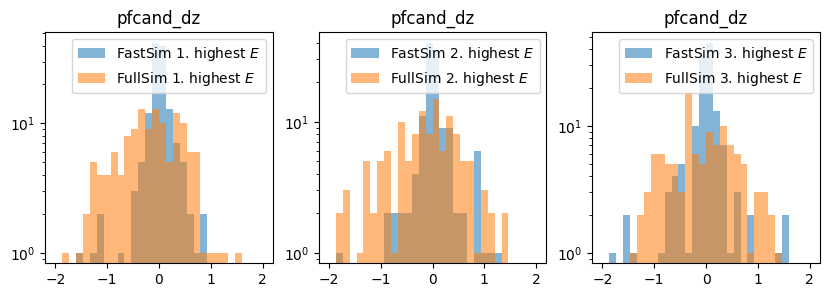

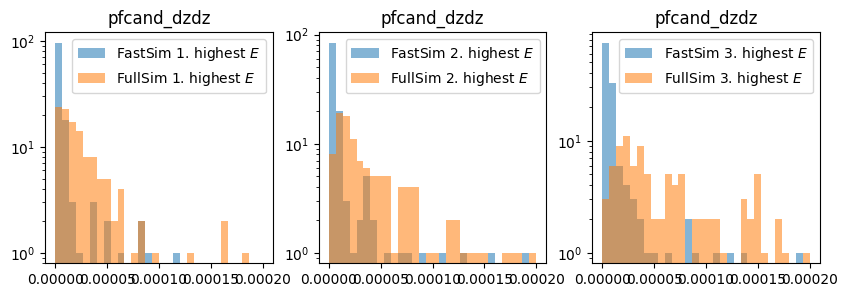

In [26]:
keys = ['pfcand_cctgtheta',
 'pfcand_cdz',
 'pfcand_detadeta',
 'pfcand_dlambdadz',
 'pfcand_phic',
 'pfcand_phictgtheta',
 'pfcand_phidz',
 'pfcand_dphidphi',
 'pfcand_dphidxy',
 'pfcand_dptdpt',
 'pfcand_dxy',
 'pfcand_dxyc',
 'pfcand_dxyctgtheta',
 'pfcand_dxydxy',
 'pfcand_dxydz',
 'pfcand_dz',
 'pfcand_dzdz']
ranges = {
    'pfcand_dz': [-2, 2],
    'pfcand_dxy': [-0.5, 0.5],
    'pfcand_cctgtheta': [-1e-10, 1e-10],
    'pfcand_cdz': [-0.2e-08, 0.2e-08],
    'pfcand_detadeta': [0, 0.25e-5],
    'pfcand_dlambdadz': [-0.05e-3, 0],
    'pfcand_phic': [-0.25e-10, 0.25e-10],
    'pfcand_phictgtheta': [-0.5e-08, 0.5e-08], 
    'pfcand_phidz': [-0.1e-6, 0.1e-6],
    'pfcand_dphidphi': [0.0, 1e-6], 
    'pfcand_dphidxy': [-2e-5, 0],
    'pfcand_dptdpt': [0, 0.5e-13], 
    'pfcand_dxyc': [-0.25e-9, 0.25e-9],
    'pfcand_dxyctgtheta': [-0.1e-6, 0.1e-6], 
    'pfcand_dxydxy': [0, 1e-4],
    'pfcand_dxydz': [-0.25e-5, 0.25e-5], # here
    'pfcand_dzdz': [0, 2e-4],
}

for key in keys:
    plot_key_highest_e_part(key, range=ranges[key], bins=30, log=True)

FCCAnalyses https://github.com/HEP-FCC/FCCAnalyses/blob/master/examples/FCCee/weaver/config.py

Off are: 
- `dz` wider in FullSim
- `dptdpt` not same distribution
- `dxydz` wider in FullSim
- `dzdz` wider in FullSim

There are so many outliner, quite hard to compare...

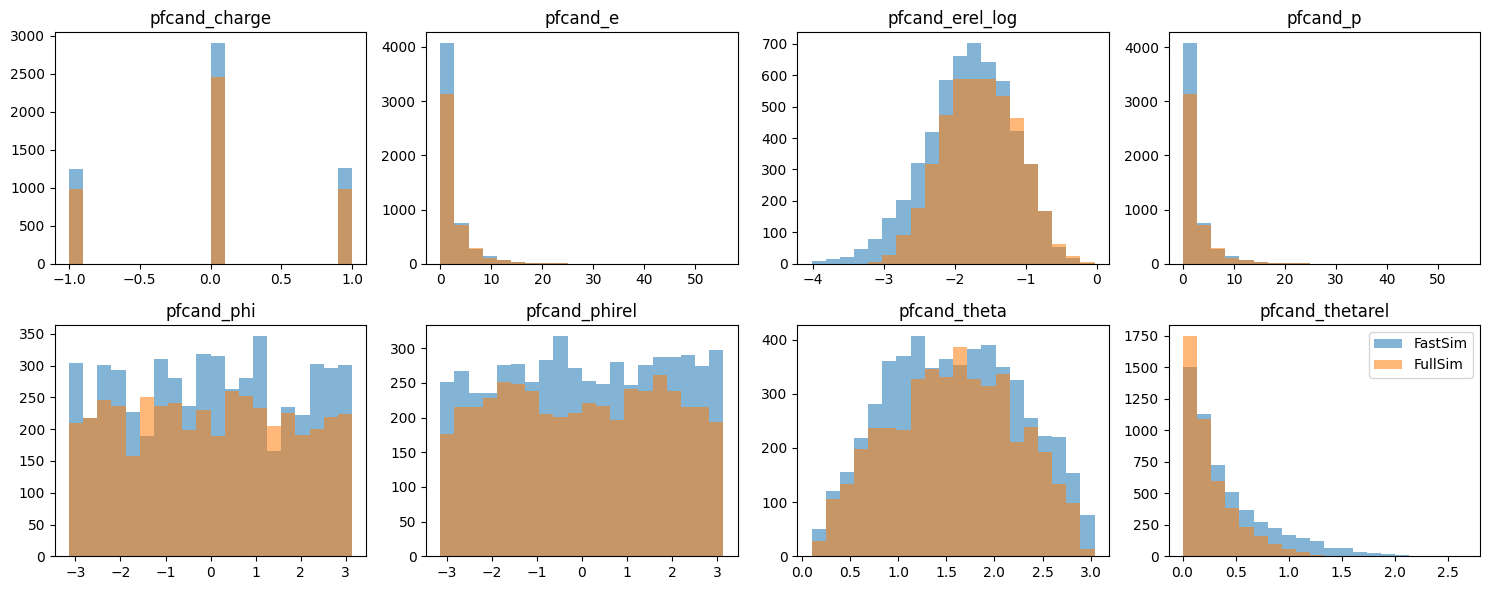

In [31]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

histograms(keys, 2, 4, figsize=(15, 6), bins=20, conc=True)

In [32]:
print(df_fa['pfcand_erel_log'].shape)
print(df_fu['pfcand_erel_log'].shape)

(200,)
(200,)


Looks good now :-) More nconst in Fastsim?

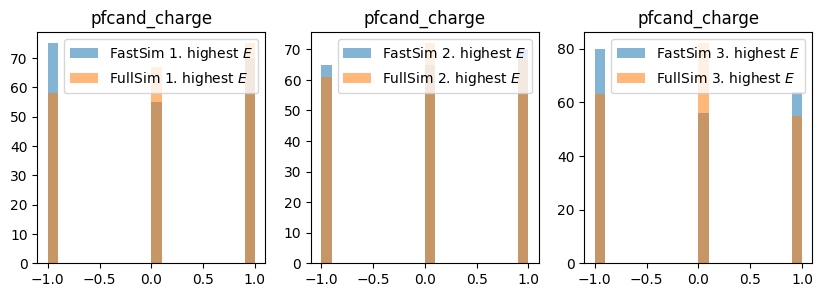

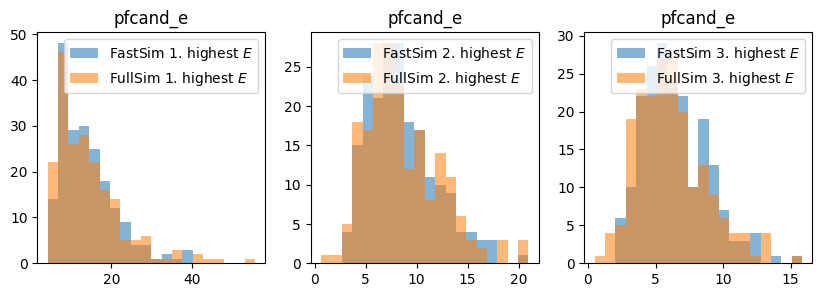

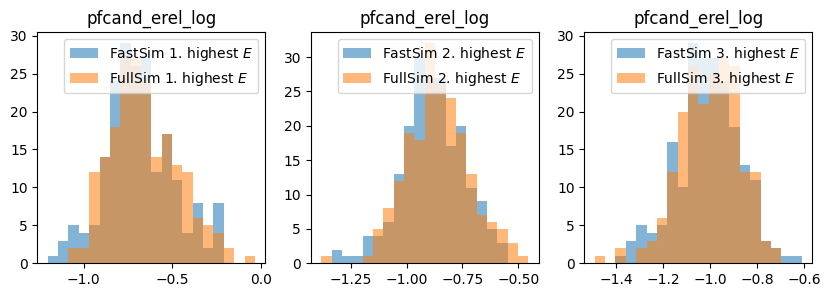

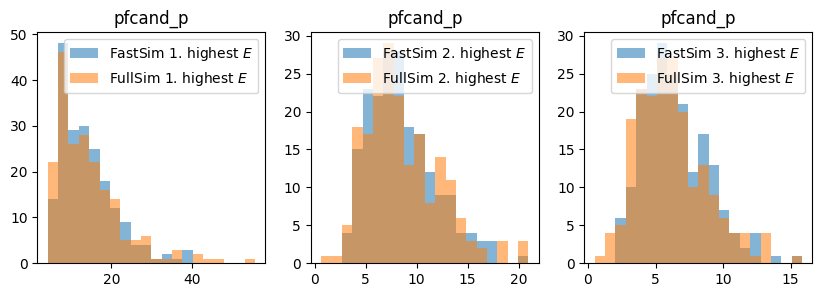

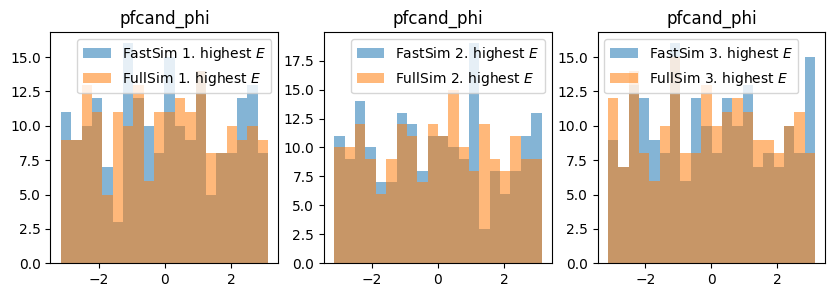

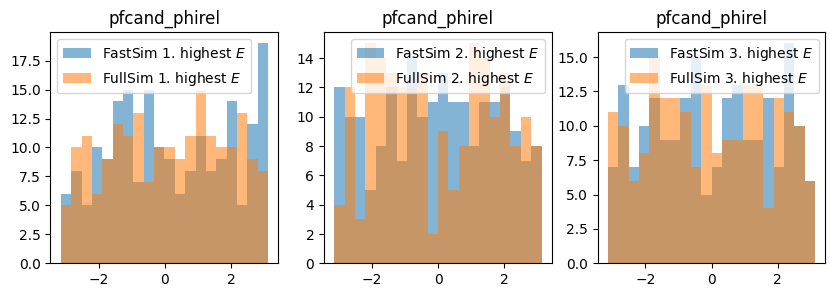

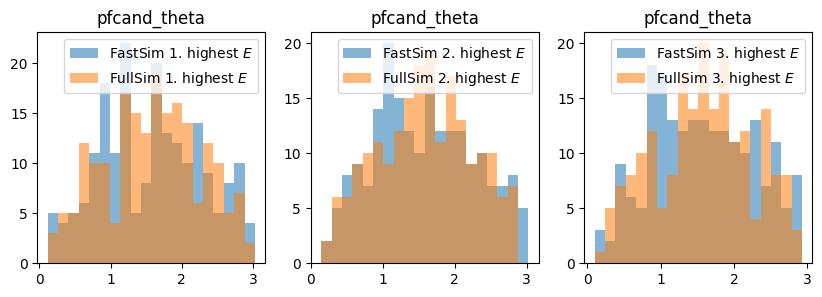

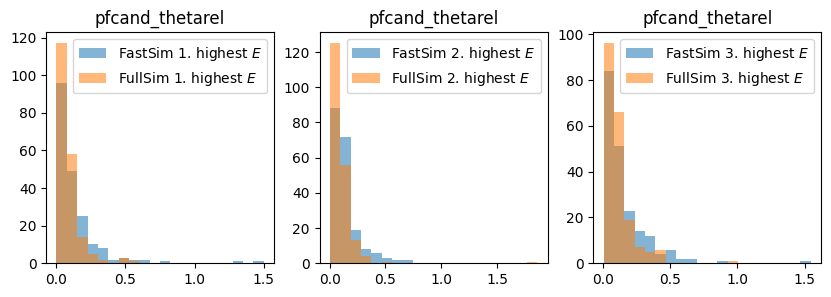

In [33]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

for key in keys:
    plot_key_highest_e_part(key)

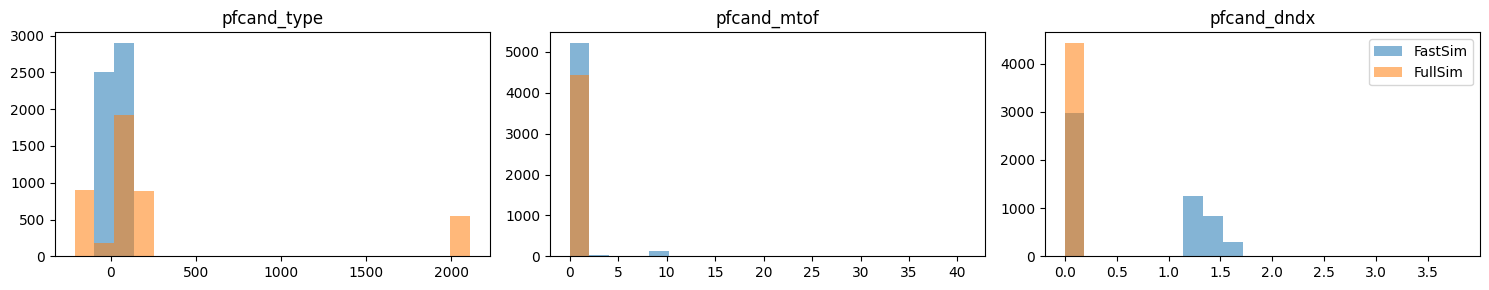

In [35]:
keys = ['pfcand_type', 'pfcand_mtof', 'pfcand_dndx']

histograms(keys, 1, 3, figsize=(15, 3), bins=20, conc=True)

it's normal that `pfcand_mtof` is off and `pfcand_dndx` because it set them to zero. 

But `pfcand_type` not... 

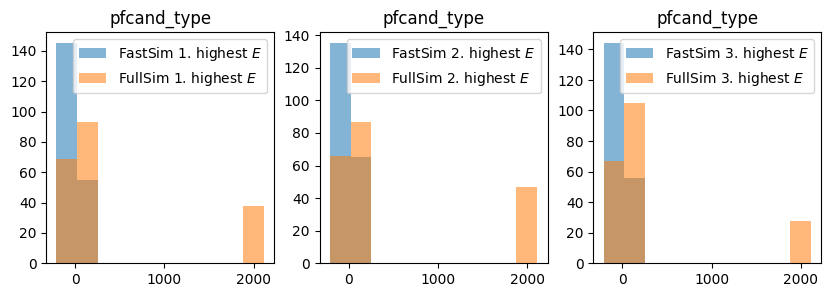

In [36]:
plot_key_highest_e_part('pfcand_type', k=3, bins=10)

In [37]:
from collections import defaultdict

In [38]:
def count_values(arrays, flatten=True):
    count_dict = defaultdict(int)
    
    # Flatten the array of arrays
    if flatten:
        flattened = np.concatenate(arrays)
    else:
        flattened = arrays
    
    # Count each value in the flattened array
    for value in flattened:
        count_dict[value] += 1
    
    return dict(count_dict)

In [39]:
count_values(df_fa['pfcand_type'])

{0.0: 2507, 22.0: 2678, 130.0: 223}

In [40]:
count_values(df_fu['pfcand_type'])

{211: 883, -211: 896, 22: 1921, 2112: 543, 11: 66, -11: 73, 13: 24, -13: 22}

In [41]:
np.sum(df_fu['jet_nnhad']) #543

543

In [42]:
np.sum(df_fu['jet_nchad']) #883 + 896 = 1779 check

1779

Well, we see that we have a lot more particle typed identified in full sim than in fast sim. FastSim has 0 while Fullsim doesn't have that option.

## Open questions
- keys (three more in fullsim - we need them?)
- how to check if tree structure is the same?
- `recojet_isX` is wrong - how to deal with that?
- which values are MC and with one reconstructed?
- SIP sig values:-9 doesn't make sense
- covariance values ok?
- `pfcand_anglerel` are off - why?
- `pfcand_type`: different values and handle 0?

# Plots for charged particles and neutral particles

I would like to redo some plots, showing them for charged (neutral) particles only. 

First, let's get the indices of the highest energetic particles which are also charged:

In [53]:
def get_index_charged_particles(df):
    if df == 'fa':
        types = df_fa['pfcand_type']
        num = [0]
    elif df == 'fu':
        types = df_fu['pfcand_type']
        num = [-211, -13, -11, 11, 13, 211] 
    mask_bool_chad = []
    for i in range(types.shape[0]):
        index = np.where(np.isin(types[i], num))[0]
        bool_list = np.zeros(len(types[i]), dtype=bool)
        bool_list[index] = True
        mask_bool_chad.append(bool_list)
    return mask_bool_chad

In [54]:
def get_value_highest_energy_particle(df, k=3):
    """return the index of the k highest energy charged particle in each event"""
    if df == 'fa':
        particles_e = df_fa['pfcand_e']
        mask_chad = get_index_charged_particles('fa')
    elif df == 'fu':
        particles_e = df_fu['pfcand_e']
        mask_chad = get_index_charged_particles('fu')
    index_charged = []
    for i  in range(particles_e.shape[0]):
        part_e = particles_e[i]
        ind = np.argpartition(part_e, -k)
        ind = ind[np.argsort(part_e[ind])[::-1]]
        mask = mask_chad[i]
        c_index = ind[mask]
        index_charged.append(c_index[:k])
    return index_charged

In [55]:
# these are lists because there might not always be 3 charged particles
index_charged_3E_fu = get_value_highest_energy_particle("fu")
index_charged_3E_fa = get_value_highest_energy_particle("fa")

Now, let's get the values for key and make a function to plot them.

In [56]:
def get_chad_elements(df_value, index):
    e_1 = []
    e_2 = []
    e_3 = []
    for i in range(len(df_value)):
        index_list = index[i] # this can have 1, 2 or 3 elements
        if len(index_list) == 1:
            e_1.append(df_value[i][index_list[0]])
        elif len(index_list) == 2:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
        elif len(index_list) == 3:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
            e_3.append(df_value[i][index_list[2]])
    return [np.array(e_1), np.array(e_2), np.array(e_3)]

In [57]:
def plot_key_highest_e_chad(key, k=3, range=None, bins=20, log=False):
    fig, axs = plt.subplots(1, k, figsize=(10,3))

    a_list = get_chad_elements(df_fa[key], index_charged_3E_fa)
    b_list = get_chad_elements(df_fu[key], index_charged_3E_fu)

    for i, ax in enumerate(axs.flat):
        a = a_list[i]
        b = b_list[i]
        a = a[a!=-9]
        b = b[b!=-9]

        if range == None:
            combined_min = min(a.min(), b.min())
            combined_max = max(a.max(), b.max())
            combined_range = (combined_min, combined_max)
        else:
            combined_range = range
        
        ax.set_title(key)
        ax.hist(a, bins=bins, alpha=0.55, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$')
        ax.hist(b, bins=bins, alpha=0.55, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$')
        if log:
            ax.set_yscale('log')
        ax.legend()
        
    plt.show()

Lovely. Now we can plots stuff! 

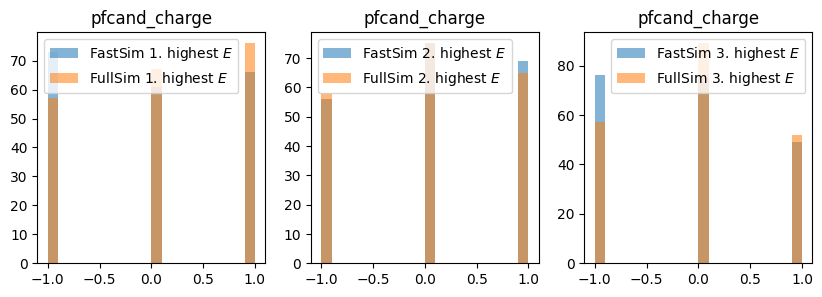

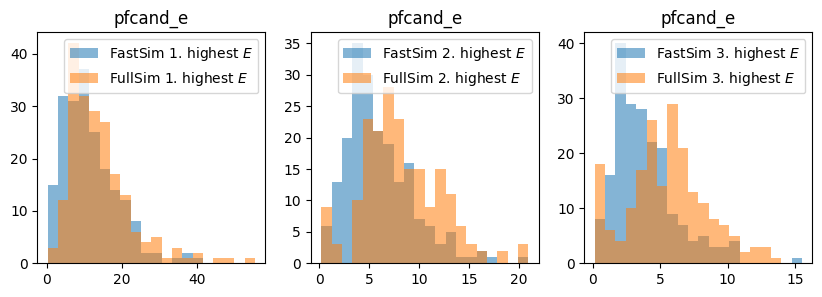

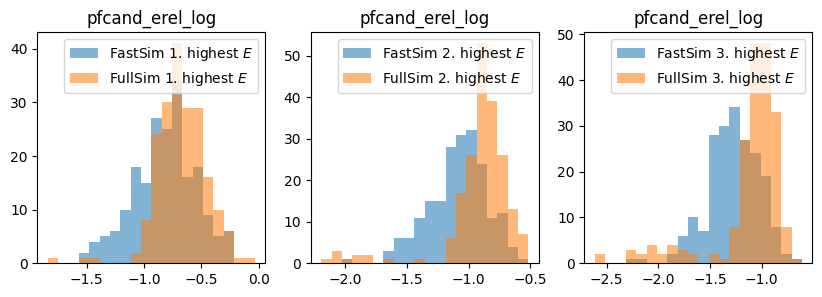

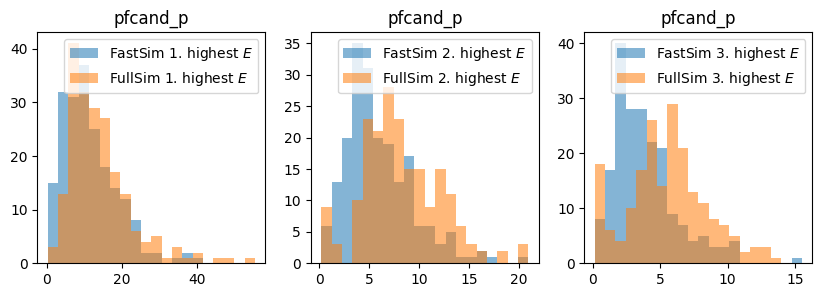

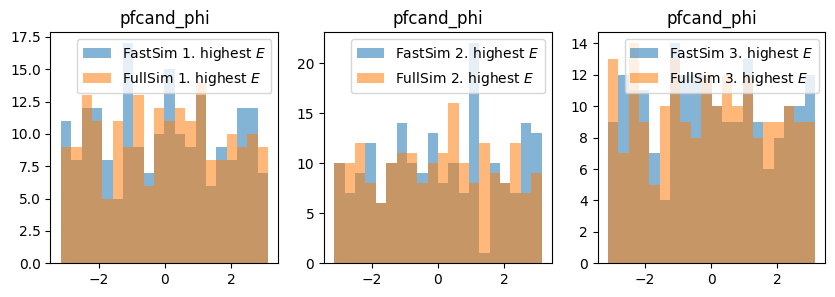

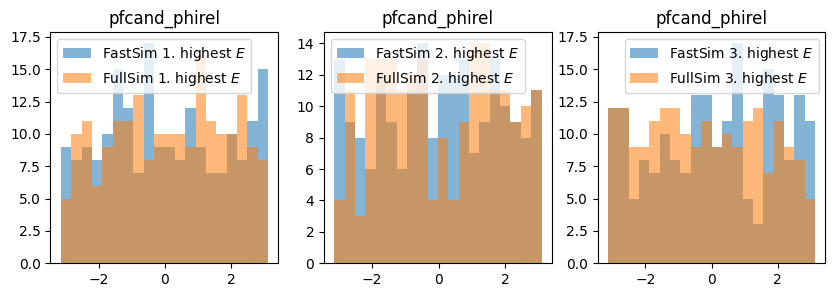

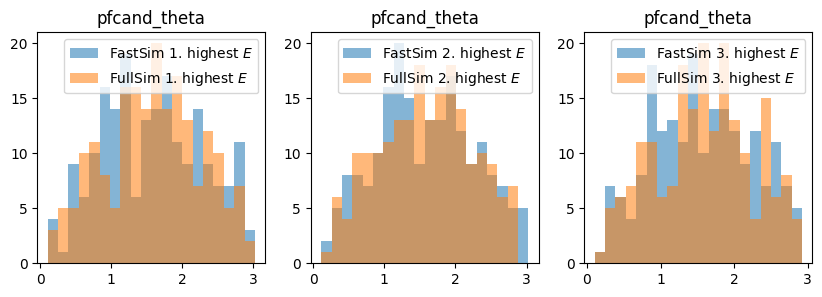

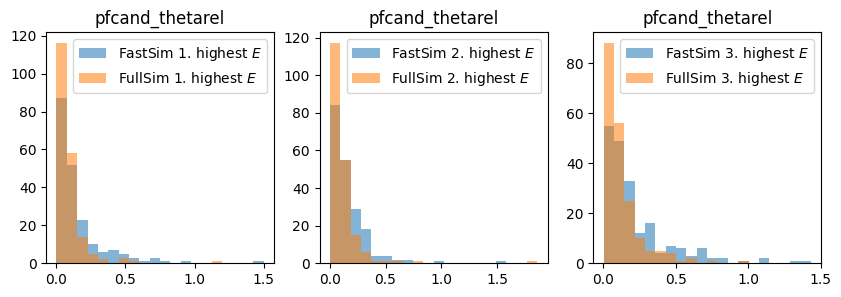

In [58]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

for key in keys:
    plot_key_highest_e_chad(key)

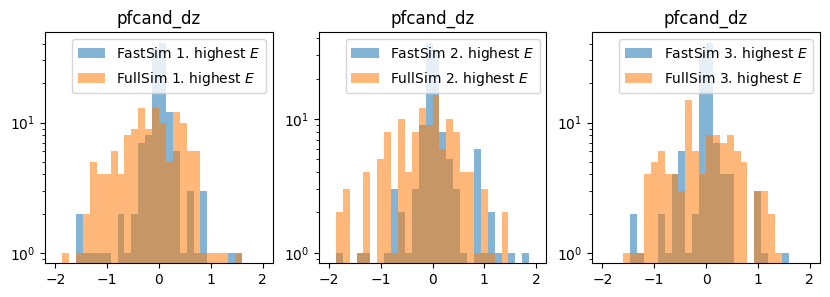

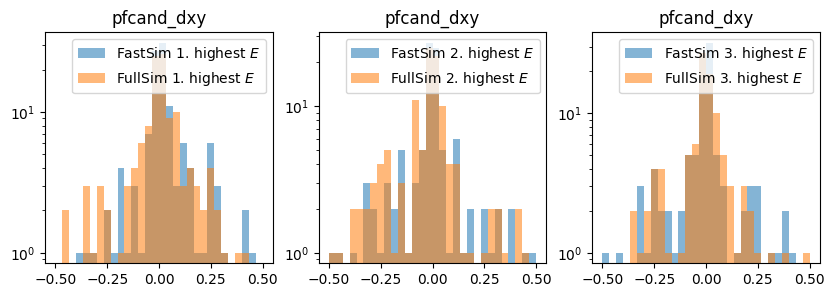

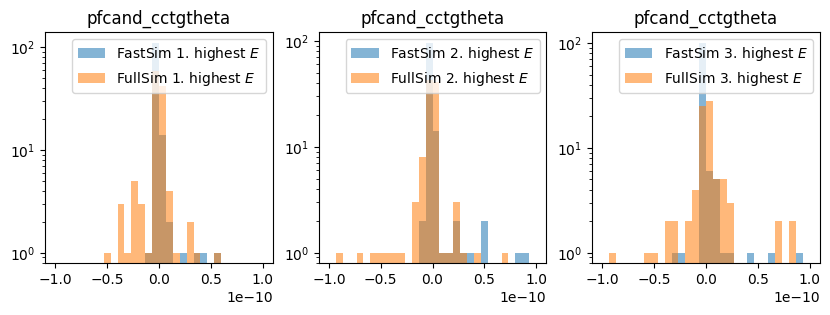

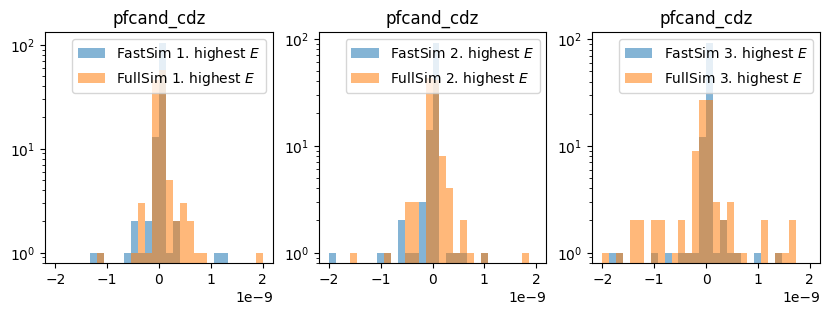

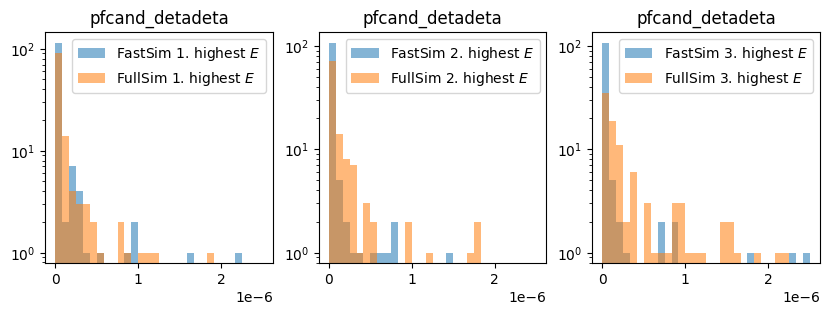

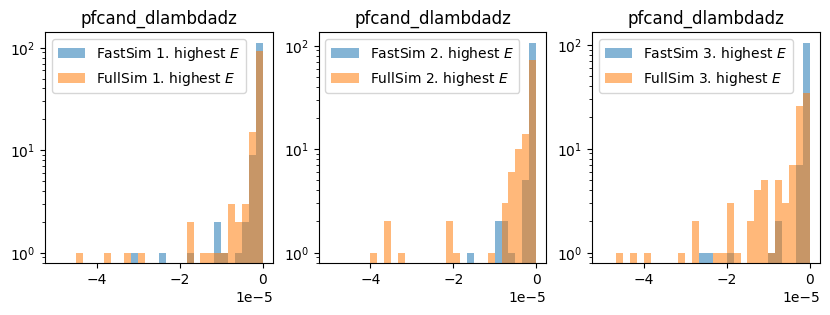

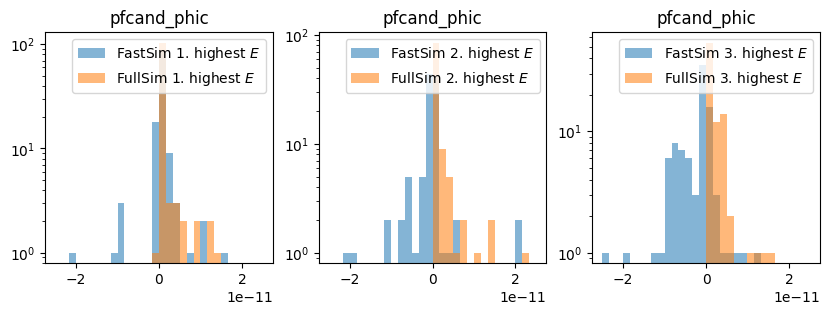

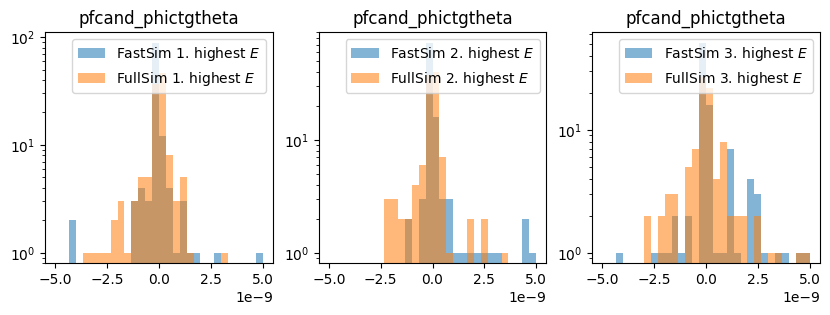

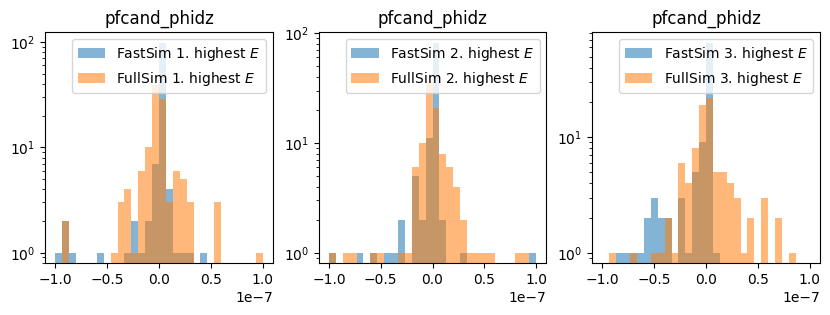

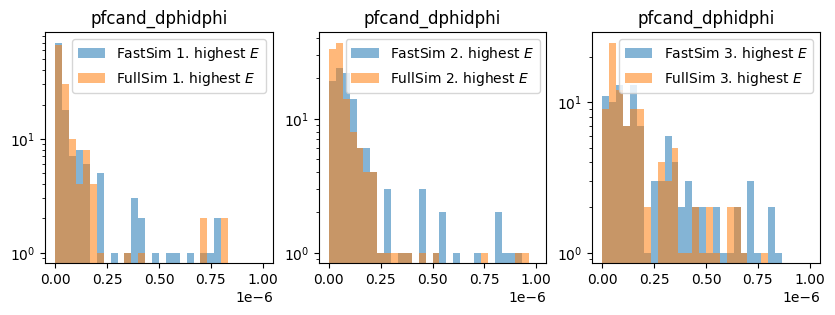

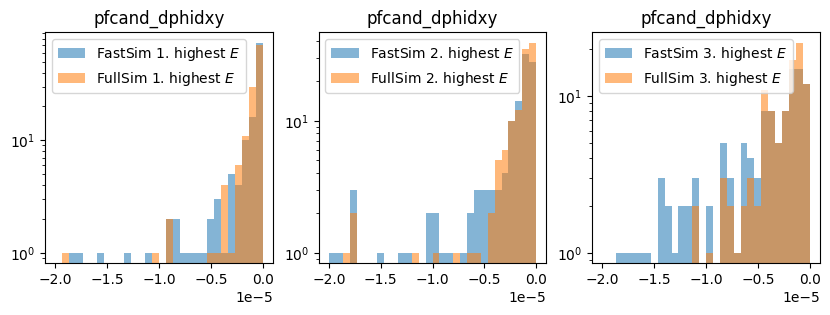

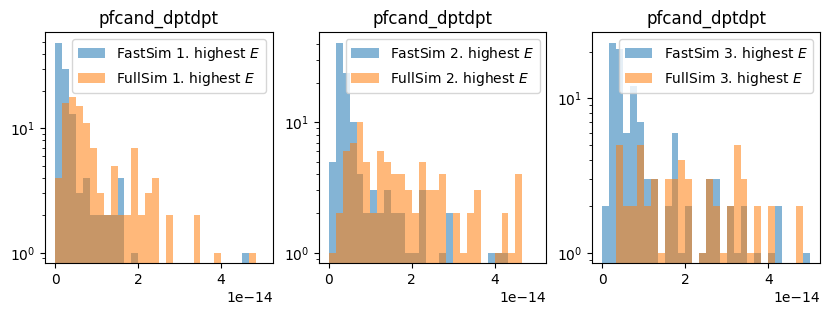

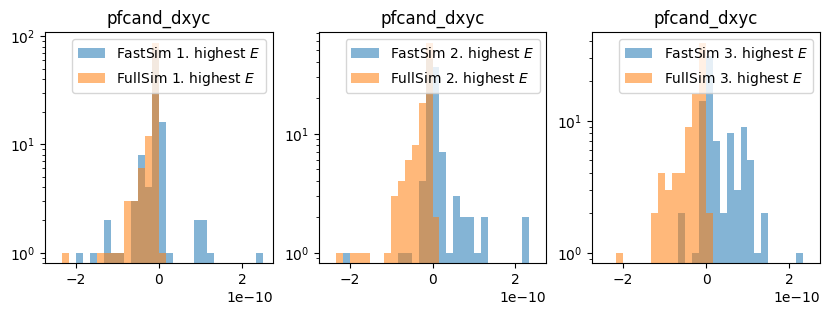

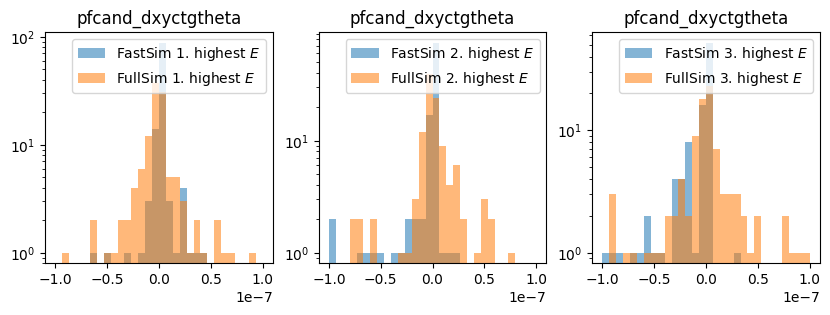

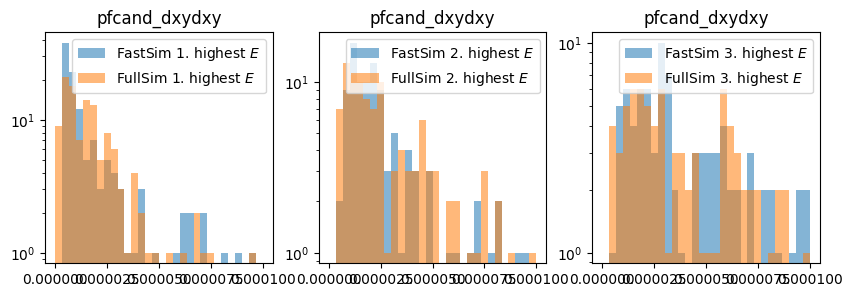

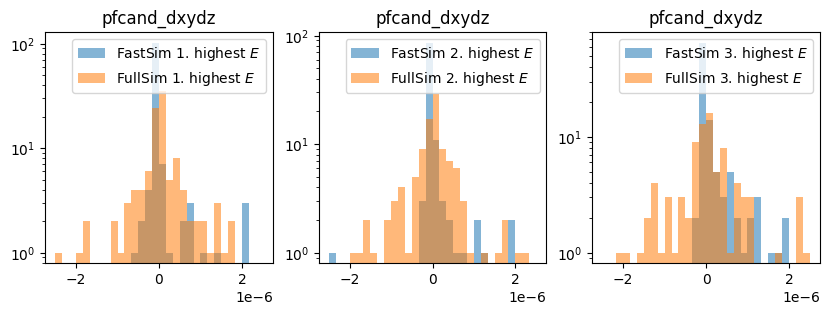

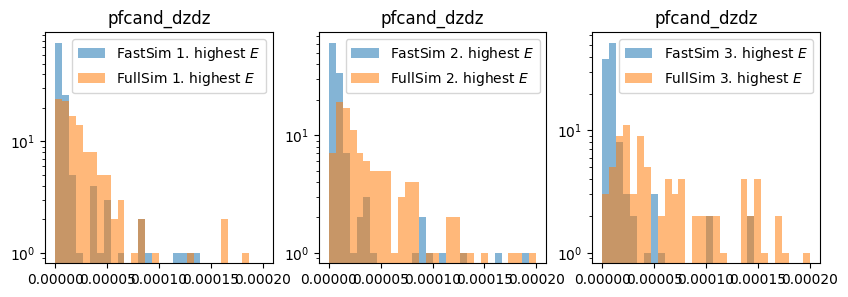

In [59]:
# this plot should be better because we look at charged hadrons only which leave a track!

keys = ['pfcand_dz',
        'pfcand_dxy',
        'pfcand_cctgtheta',
 'pfcand_cdz',
 'pfcand_detadeta',
 'pfcand_dlambdadz',
 'pfcand_phic',
 'pfcand_phictgtheta',
 'pfcand_phidz',
 'pfcand_dphidphi',
 'pfcand_dphidxy',
 'pfcand_dptdpt',
 'pfcand_dxyc',
 'pfcand_dxyctgtheta',
 'pfcand_dxydxy',
 'pfcand_dxydz',
 'pfcand_dzdz']

ranges = {
    'pfcand_dz': [-2, 2],
    'pfcand_dxy': [-0.5, 0.5],
    'pfcand_cctgtheta': [-1e-10, 1e-10],
    'pfcand_cdz': [-0.2e-08, 0.2e-08],
    'pfcand_detadeta': [0, 0.25e-5],
    'pfcand_dlambdadz': [-0.05e-3, 0],
    'pfcand_phic': [-0.25e-10, 0.25e-10],
    'pfcand_phictgtheta': [-0.5e-08, 0.5e-08], 
    'pfcand_phidz': [-0.1e-6, 0.1e-6],
    'pfcand_dphidphi': [0.0, 1e-6], 
    'pfcand_dphidxy': [-2e-5, 0],
    'pfcand_dptdpt': [0, 0.5e-13], 
    'pfcand_dxyc': [-0.25e-9, 0.25e-9],
    'pfcand_dxyctgtheta': [-0.1e-6, 0.1e-6], 
    'pfcand_dxydxy': [0, 1e-4],
    'pfcand_dxydz': [-0.25e-5, 0.25e-5], # here
    'pfcand_dzdz': [0, 2e-4],
}

for key in keys:
    plot_key_highest_e_chad(key, bins=30, range=ranges[key], log=True)

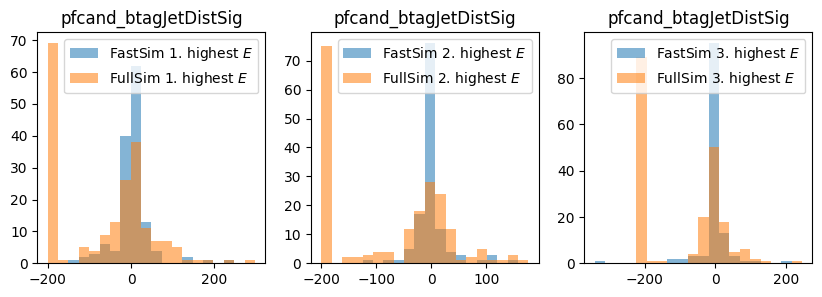

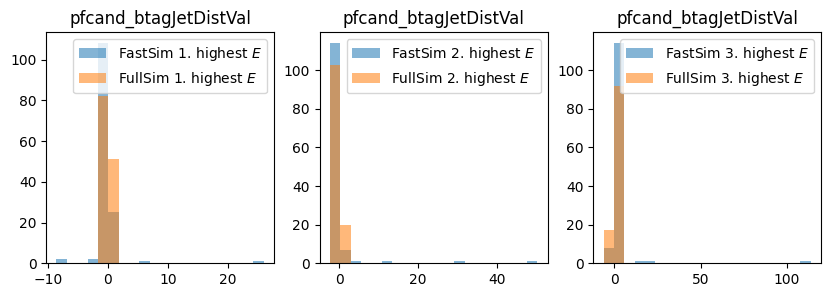

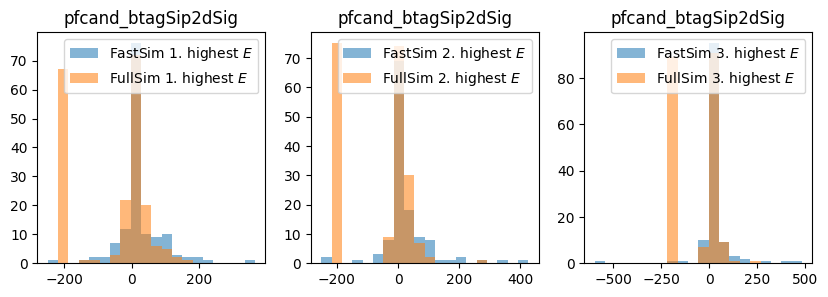

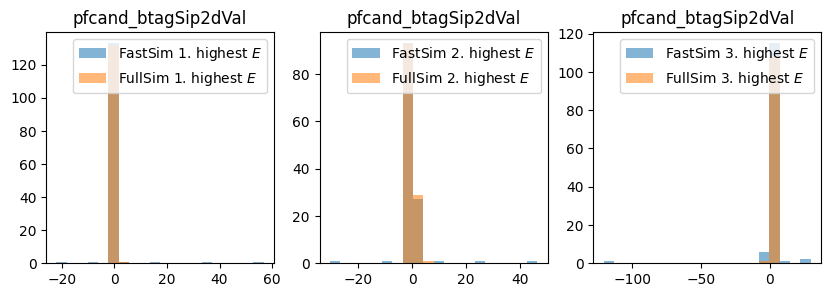

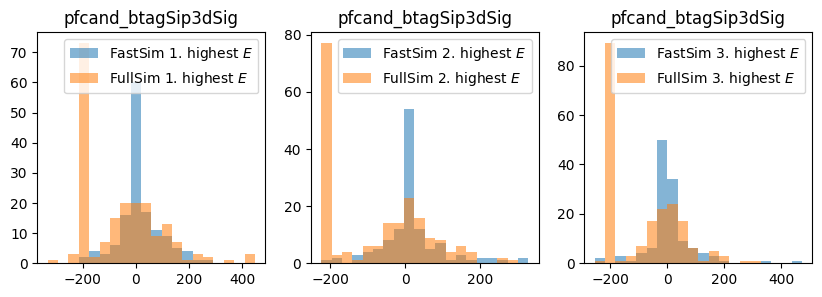

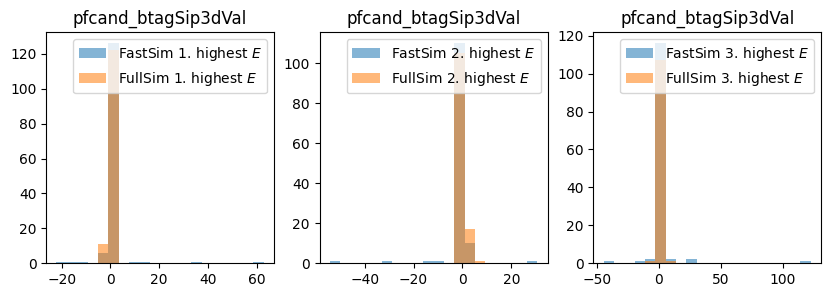

In [60]:
# these plots make even more sense than the one above because we look at charged hadrons only which leave a track!

keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

for key in keys:
    plot_key_highest_e_chad(key)

## Notes

Next things to do: 
- ranges for sip values
- do the same for neutral particles